In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Data Preparation Function


In [ ]:
labels = ['Non Oil Spill', 'Oil Spill']

img_size = 150

def load_data(directory):
    data = []
    for label in labels:
        path = os.path.join(directory, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path)[...,::-1]

            if img_arr is not None:
                img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([img_arr, class_num])
    return np.array(data, dtype=object)



# Data Loading

In [ ]:
train=load_data('/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/train')
test=load_data('/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/test')
val=load_data('/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/Validation')

# Data Analysis: Class Distribution

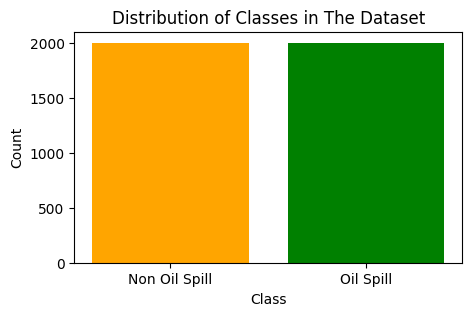

In [ ]:
data=np.concatenate((train, val, test))
val_labels = [item[1] for item in data]


class_counts = {'Non Oil Spill': val_labels.count(0), 'Oil Spill': val_labels.count(1)}


plt.figure(figsize=(5, 3))
plt.bar(class_counts.keys(), class_counts.values(), color=['orange', 'green'])
plt.title('Distribution of Classes in The Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Visualizing Sample Images



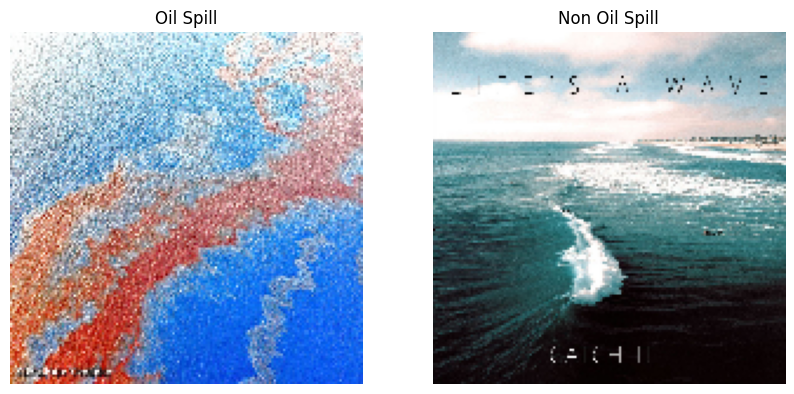

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(train[-1][0])
axes[0].set_title(labels[train[-1][1]])
axes[0].axis('off')


axes[1].imshow(train[1][0])
axes[1].set_title(labels[train[1][1]])
axes[1].axis('off')


plt.show()

# Data Formatting and Reshaping


In [ ]:
def populate_data(data):
    features, labels = zip(*data)
    return np.array(features) / 255.0, np.array(labels)

In [ ]:
x_train, y_train = populate_data(train)
x_val, y_val = populate_data(val)
x_test, y_test = populate_data(test)

In [ ]:
x_train = x_train.reshape(2800, 150, 150, 3)
x_test = x_test.reshape(600, 150, 150, 3)
x_val = x_val.reshape(600, 150, 150, 3)


print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (2800, 150, 150, 3)
y_train: (2800,)
x_test: (600, 150, 150, 3)
y_test: (600,)
x_val: (600, 150, 150, 3)
y_val: (600,)


# Data Augmentation

In [ ]:

datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

# CNN Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       175,233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,129 (688.00 KB)

 Trainable params: 176,129 (688.00 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), shuffle=True, batch_size=64)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5626 - loss: 2.1897 - val_accuracy: 0.7650 - val_loss: 0.4726
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8954 - loss: 0.3172 - val_accuracy: 0.9250 - val_loss: 0.2536
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9559 - loss: 0.1693 - val_accuracy: 0.9400 - val_loss: 0.1869
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9841 - loss: 0.0907 - val_accuracy: 0.9667 - val_loss: 0.1214
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9885 - loss: 0.0730 - val_accuracy: 0.9683 - val_loss: 0.1009
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9914 - loss: 0.0539 - val_accuracy: 0.9733 - val_loss: 0.0833
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9940 - loss: 0.0378 - val_accuracy: 0.9567 - val_loss: 0.1019
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9943 - loss: 0.0313 - val_accuracy: 0.9617 - v

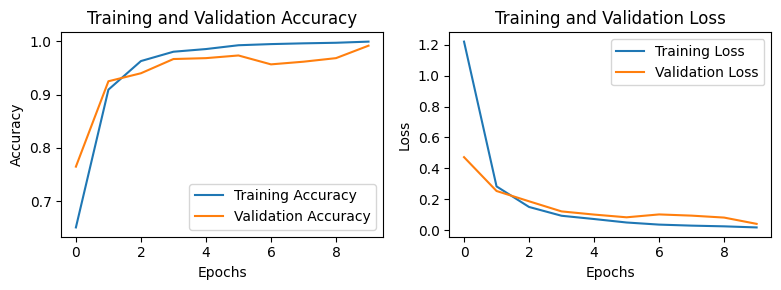

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(train_accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
y_prob = model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
# Apply threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_prob > threshold).astype(int)
y_pred[0:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Accuracy: 0.992
Precision: 0.993
Recall: 0.99000


> **Accuracy** indicates the percentage of correct predictions made by the model out of all instances. In oil spill classification, this metric provides a general summary of how accurately the model identifies both oil spill and non-oil spill cases, reflecting its overall effectiveness across all predictions.

> **Precision** is important in situations where reducing false positives is crucial. In oil spill classification, it reflects how often the model correctly identifies an oil spill when it predicts one. High precision shows that the model reliably detects actual oil spills and doesn't frequently mislabel non-oil spills as oil spills.

> **Recall** indicates how many actual oil spills the model successfully identifies. In the context of oil spill detection, high recall means the model effectively captures most oil spills, which is crucial for reducing the risk of undetected incidents.

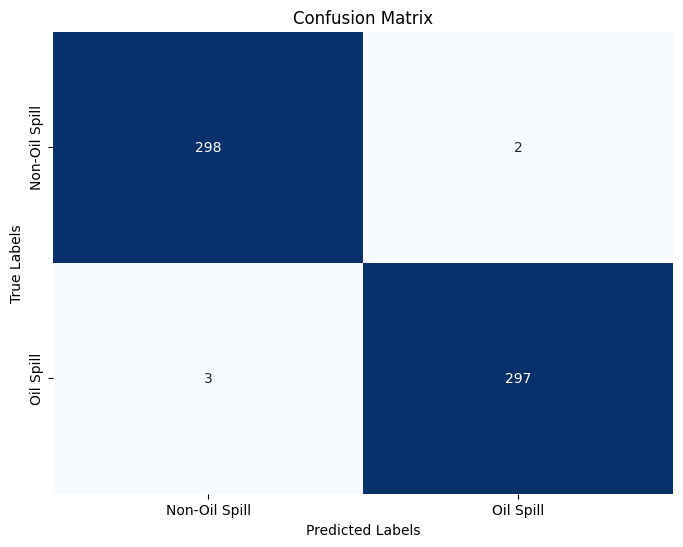

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Oil Spill', 'Oil Spill'],
            yticklabels=['Non-Oil Spill', 'Oil Spill'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

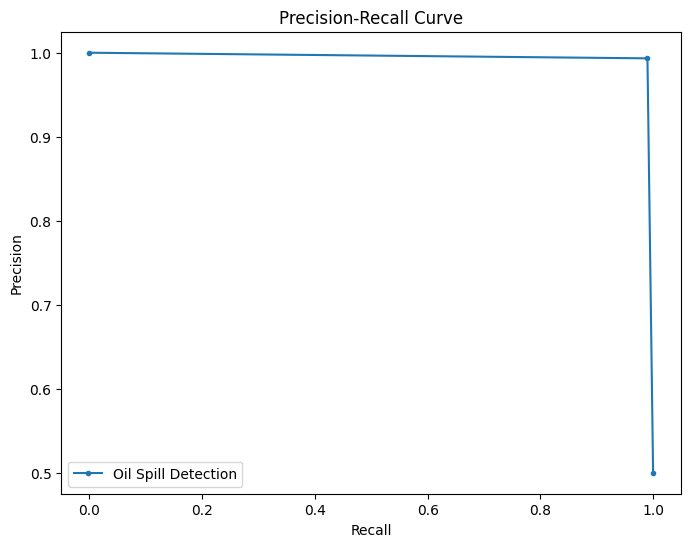

In [ ]:
# Get precision-recall curve values
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, marker='.', label='Oil Spill Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

> The Precision-Recall (PR) curve illustrates the model's effectiveness in classifying oil spills. With an accuracy of 99%, the model reliably distinguishes between oil spill and non-oil spill instances. The precision score of 0.99 indicates that out of all images predicted as oil spills images, 99% are actually oil spills images. The recall value of 0.99 demonstrates that the model correctly identifies 99% of actual oil spills, ensuring that most spills are detected.

#Save the Model

In [ ]:
model.save('SimpleCNN.h5')

# Function to Classify image as 'Non Oil Spill' or 'Oil Spill' based on the trained model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


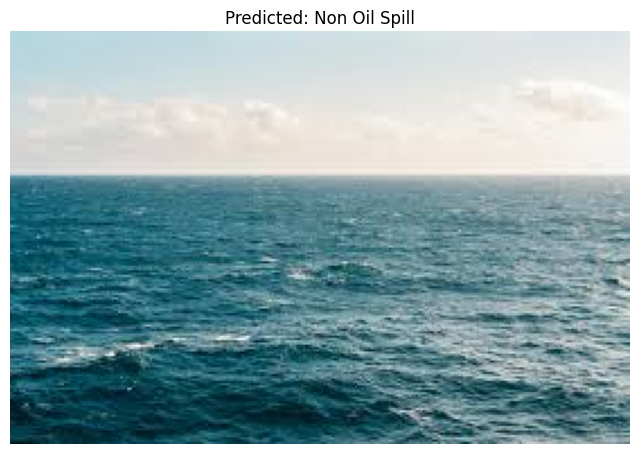

The predicted class is: Non Oil Spill


In [ ]:
model = tf.keras.models.load_model('SimpleCNN.h5')

def predict_and_show(image_path, img_size=150):
    img = cv2.imread(image_path)

    if img is None:
        print("Error: Unable to load the image. Please check the image path.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized / 255.0
    img_reshaped = np.reshape(img_normalized, (1, img_size, img_size, 3))

    oil_spill_probability = model.predict(img_reshaped)[0][0]

    predicted_class = "Oil Spill" if oil_spill_probability > 0.5 else "Non Oil Spill"

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"The predicted class is: {predicted_class}")


image_path = '/kaggle/input/non-oil-spill2/non oil spill.jfif'
predict_and_show(image_path)